In [1]:
!pip install transformers datasets scikit-learn --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments
import torch
import os, time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [16]:
# Load dataset
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipython-input-16-1827933523.py:2: ParserWarning: Skipping line 341687: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


In [17]:
df = df.sample(15000)

In [18]:
df['label'].value_counts()

,count
label,
1,12520
0,2480


In [19]:
# Step 4: Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [20]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

In [21]:
# Dataset class
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonDataset(train_encodings, train_labels)
val_dataset = AmazonDataset(val_encodings, val_labels)

In [22]:
model = ElectraForSequenceClassification.from_pretrained(
    'google/electra-base-discriminator',
    num_labels=2
)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Training arguments
os.environ["WANDB_DISABLED"] = "true"  # Disable W&B tracking

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/ELECTRA_Sentiment/results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    logging_dir='/content/drive/MyDrive/ELECTRA_Sentiment/logs',
    logging_steps=10,
    save_strategy="no"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


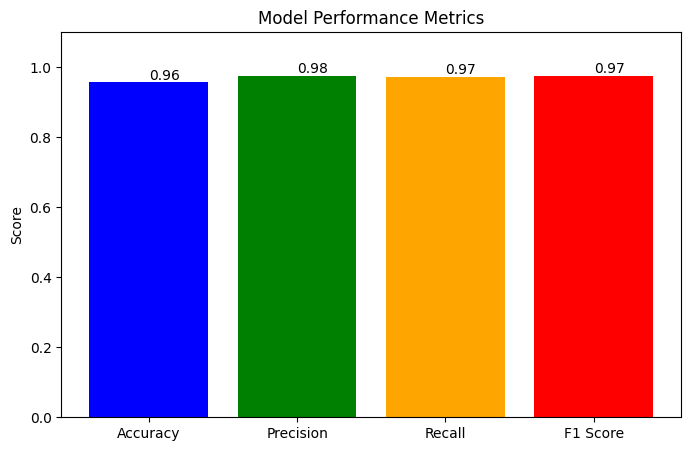

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [acc, prec, rec, f1]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom') # va: vertical alignment

# Add labels and title
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.ylim(0, 1.1)
plt.show()

In [24]:
# Train model
start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Evaluation
start_test = time.time()
predictions = trainer.predict(val_dataset)
test_time = time.time() - start_test

y_pred = predictions.predictions.argmax(axis=-1)
y_true = val_labels[:len(y_pred)]

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")

Epoch,Training Loss,Validation Loss
1,0.174300,0.157021
2,0.083200,0.141937


Training time: 557.49 seconds


Accuracy: 0.9566666666666667
Precision: 0.975825946817083
Recall: 0.9719101123595506
F1 Score: 0.9738640932850824
Training Time: 557.49 seconds
Testing Time: 20.31 seconds
